In [161]:
# Section 1: Imports and setup

# Import required libraries for image processing, ML, and visualization
import cv2
# NumPy for numerical operations and array handling
import numpy as np
# MediaPipe for hand landmark detection
import mediapipe as mp
# Path for cross-platform file path handling
from pathlib import Path
# KNN classifier for gesture recognition
from sklearn.neighbors import KNeighborsClassifier
# Metrics for model evaluation
from sklearn.metrics import classification_report, confusion_matrix
# Cross-validation for hyperparameter tuning
from sklearn.model_selection import cross_val_score
# StandardScaler for feature normalization
from sklearn.preprocessing import StandardScaler
# Matplotlib for plotting
import matplotlib.pyplot as plt
# Seaborn for better visualizations
import seaborn as sns
# Pickle for saving trained models
import pickle

# Set random seed for reproducibility
np.random.seed(42)



In [162]:
# Section 2: Configuration and Data Paths

# Configure paths and initialize MediaPipe Hand Landmarks detector
# Paths go up one level since notebook is in training/ directory
DATA_DIR = Path("../data")
# Training data directory
TRAIN_DIR = DATA_DIR / "train"
# Test data directory
TEST_DIR = DATA_DIR / "test"
# Models directory for saving trained model
MODELS_DIR = Path("../models")
# Create models directory if it doesn't exist
MODELS_DIR.mkdir(exist_ok=True)

# Define gesture classes for mouse control
GESTURE_CLASSES = ['no_click', 'left_click', 'right_click']
# Number of gesture classes
NUM_CLASSES = len(GESTURE_CLASSES)

# Initialize MediaPipe Hand Landmarks solution
mp_hands = mp.solutions.hands
# Create Hands detector with static image mode for processing individual images
hands = mp_hands.Hands(
    static_image_mode=True,  # Process each image independently (not video stream)
    max_num_hands=1,  # Only detect one hand
    min_detection_confidence=0.3,  # Lower threshold to catch more hands
    min_tracking_confidence=0.3  # Lower threshold for tracking
)




I0000 00:00:1764886164.247421       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M3 Pro


In [163]:
# Section 3: Feature Extraction - Hand Landmark to Features

# Function to extract 28 geometric features from MediaPipe hand landmarks
def calculate_features_from_landmarks(landmarks, image_shape):
    # Get image dimensions for normalization
    h, w = image_shape[:2]
    
    # Convert MediaPipe normalized coordinates (0-1) to pixel coordinates 
    points = []
    for landmark in landmarks.landmark:
        # Convert normalized x coordinate to pixels
        x = landmark.x * w
        # Convert normalized y coordinate to pixels
        y = landmark.y * h
        points.append([x, y])
    # Convert to NumPy array for easier manipulation
    points = np.array(points)
    
    # Extract finger tip positions (landmarks 4, 8, 12, 16, 20)
    thumb_tip = points[4]
    index_tip = points[8]
    middle_tip = points[12]
    ring_tip = points[16]
    pinky_tip = points[20]
    wrist = points[0]
    
    # Determine if fingers are extended (critical for gesture recognition)
    thumb_extended = (thumb_tip[1] < points[3][1])
    index_extended = (index_tip[1] < points[6][1])
    middle_extended = (middle_tip[1] < points[10][1])
    ring_extended = (ring_tip[1] < points[14][1])
    pinky_extended = (pinky_tip[1] < points[18][1])
    num_extended = sum([thumb_extended, index_extended, middle_extended, ring_extended, pinky_extended])
    
    # Calculate key distances between fingertips (normalized by image width)
    thumb_index_dist = np.linalg.norm(thumb_tip[:2] - index_tip[:2]) / w
    thumb_middle_dist = np.linalg.norm(thumb_tip[:2] - middle_tip[:2]) / w
    index_middle_dist = np.linalg.norm(index_tip[:2] - middle_tip[:2]) / w
    thumb_pinky_dist = np.linalg.norm(thumb_tip[:2] - pinky_tip[:2]) / w
    
    # Calculate hand orientation angle from wrist to middle finger
    wrist_to_middle = middle_tip[:2] - wrist[:2]
    hand_angle = np.arctan2(wrist_to_middle[1], wrist_to_middle[0]) / np.pi
    
    # Calculate hand size (width)
    x_coords = points[:, 0]
    hand_width = (x_coords.max() - x_coords.min()) / w
    
    # Combine 12 essential features into a single array
    features = np.array([
        float(thumb_extended),  # Feature 0: Thumb extended
        float(index_extended),  # Feature 1: Index extended
        float(middle_extended), # Feature 2: Middle extended
        float(ring_extended),   # Feature 3: Ring extended
        float(pinky_extended),  # Feature 4: Pinky extended
        float(num_extended),    # Feature 5: Total extended fingers
        thumb_index_dist,       # Feature 6: Distance thumb-index
        thumb_middle_dist,      # Feature 7: Distance thumb-middle
        index_middle_dist,      # Feature 8: Distance index-middle
        thumb_pinky_dist,       # Feature 9: Distance thumb-pinky
        hand_angle,             # Feature 10: Hand orientation angle
        hand_width,             # Feature 11: Hand width
    ])
    
    return features

In [164]:
# Section 4: Feature Extraction

# Function to extract features from all images in a directory
def extract_features_from_dir(directory, gesture_classes, hands_detector):
    # Lists to store all features and labels
    all_features = []
    all_labels = []
    
    # Loop through each gesture class folder
    for class_idx, gesture in enumerate(gesture_classes):
        # Get path to gesture folder
        gesture_dir = directory / gesture
        # Find all JPG and PNG images in this folder
        image_files = list(gesture_dir.glob("*.jpg")) + list(gesture_dir.glob("*.png"))
        
        print(f"Processing {len(image_files)} images for '{gesture}'...")
        # Counter for images where hand wasn't detected
        no_hand_count = 0
        
        # Process each image
        for img_path in image_files:
            # Load image using OpenCV
            image = cv2.imread(str(img_path))
            # Skip if image couldn't be loaded
            if image is None:
                continue
            
            # OpenCV loads images as BGR, but MediaPipe needs RGB
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Use MediaPipe to detect hands in the image
            results = hands_detector.process(rgb_image)
            
            # Check if a hand was detected
            if results.multi_hand_landmarks:
                # Use the first detected hand
                landmarks = results.multi_hand_landmarks[0]
                # Extract features from hand landmarks
                features = calculate_features_from_landmarks(landmarks, image.shape)
                # Store features and corresponding label
                all_features.append(features)
                all_labels.append(class_idx)
            else:
                # Count images where hand should be detected but isn't
                no_hand_count += 1
                # Print warning for first 5 skipped images
                if no_hand_count <= 5:
                    print(f"No hand detected in {img_path.name}")
        
        # Print summary of skipped images
        if no_hand_count > 0:
            print(f"  ({no_hand_count} images skipped - no hand detected)")
    
    # Convert to NumPy arrays for easier handling
    return np.array(all_features), np.array(all_labels)

print("Feature extraction function defined")


Feature extraction function defined


In [165]:
# Section 5: Data Processing from Training Set

# Extract features from all training images
print("Extracting features from training data...")
# Extract features and labels from training directory
X_train_features, y_train = extract_features_from_dir(TRAIN_DIR, GESTURE_CLASSES, hands)

# Print summary of extracted training data
print(f"\nTraining features shape: {X_train_features.shape}")
print(f"Training labels shape: {y_train.shape}")
if len(X_train_features) > 0:
    print(f"Number of features per image: {X_train_features.shape[1]}")
    print(f"Number of training examples: {len(X_train_features)}")


Extracting features from training data...
Processing 317 images for 'no_click'...
No hand detected in open_hand_20251204_113245_052.jpg
No hand detected in open_hand_20251204_113236_080.jpg
No hand detected in open_hand_20251204_113257_618.jpg
No hand detected in open_hand_20251204_113301_998.jpg
No hand detected in open_hand_20251204_113338_316.jpg
  (26 images skipped - no hand detected)
Processing 316 images for 'left_click'...
No hand detected in fist_20251204_113824_771.jpg
No hand detected in fist_20251204_113815_108.jpg
No hand detected in fist_20251204_113822_709.jpg
No hand detected in fist_20251204_113815_245.jpg
No hand detected in fist_20251204_113815_873.jpg
  (35 images skipped - no hand detected)
Processing 304 images for 'right_click'...
No hand detected in two_fingers_20251204_113540_138.jpg
No hand detected in two_fingers_20251204_113602_215.jpg
No hand detected in two_fingers_20251204_113616_745.jpg
No hand detected in two_fingers_20251204_113545_479.jpg
No hand dete

In [166]:

# Extract features from test data (model will never see these during training)
print("Extracting features from test data...")
# Extract features and labels from test directory
X_test_features, y_test = extract_features_from_dir(TEST_DIR, GESTURE_CLASSES, hands)

# Print summary of extracted test data
print(f"\nTest features shape: {X_test_features.shape}")
print(f"Test labels shape: {y_test.shape}")


Extracting features from test data...
Processing 137 images for 'no_click'...
No hand detected in open_hand_20251204_113406_985.jpg
No hand detected in open_hand_20251204_113337_652.jpg
No hand detected in open_hand_20251204_113344_520.jpg
No hand detected in no_click_20251204_170155_402.jpg
  (4 images skipped - no hand detected)
Processing 134 images for 'left_click'...
No hand detected in fist_20251204_113815_444.jpg
No hand detected in fist_20251204_113814_903.jpg
No hand detected in fist_20251204_113811_676.jpg
No hand detected in fist_20251204_113811_011.jpg
No hand detected in fist_20251204_113829_087.jpg
  (19 images skipped - no hand detected)
Processing 147 images for 'right_click'...
No hand detected in two_fingers_20251204_113533_101.jpg
No hand detected in two_fingers_20251204_113625_428.jpg
No hand detected in two_fingers_20251204_113604_245.jpg
No hand detected in two_fingers_20251204_113623_295.jpg
No hand detected in two_fingers_20251204_113623_532.jpg
  (101 images sk

In [167]:
# Section 7: Feature Normalization

# Normalize features so all features contribute equally to KNN distance calculation
# Create StandardScaler to transform features to mean=0, std=1
scaler = StandardScaler()

# Fit scaler on training data (learns mean and std) and transform training features
X_train_scaled = scaler.fit_transform(X_train_features)

# Transform test data using the SAME scaler (don't fit again, use training statistics)
X_test_scaled = scaler.transform(X_test_features)

print("Features normalized")
# Verify normalization worked (mean should be ~0, std should be ~1)
print(f"After normalization:")
print(f"Training data mean: {X_train_scaled.mean(axis=0)[:3]}...")
print(f"Training data std: {X_train_scaled.std(axis=0)[:3]}...")


Features normalized
After normalization:
Training data mean: [-1.67300937e-15  1.15749161e-15 -1.29769932e-15]...
Training data std: [1. 1. 1.]...


In [168]:
# Section 8: Hyperparameter Tuning

# Find best K value using cross-validation
# Test K values from 1 to 15
k_values = list(range(1, 16))
# Store cross-validation scores for each K
k_scores = []


# Test each K value
for k in k_values:
    # Create temporary KNN classifier with current K
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    # Perform 5-fold cross-validation on training data
    scores = cross_val_score(knn_temp, X_train_scaled, y_train, cv=5, scoring='accuracy')
    # Calculate mean accuracy across folds
    mean_score = scores.mean()
    # Store score
    k_scores.append(mean_score)
    
    # Print score for K values 1-5, even numbers, and 15
    if k <= 5 or k % 2 == 0 or k == 15:
        print(f"K={k:2d}: {mean_score:.4f}")

# Find K value with highest cross-validation score
best_k_idx = np.argmax(k_scores)
best_k = k_values[best_k_idx]
best_score = k_scores[best_k_idx]

print(f"\nBest K: {best_k} (cross-validation accuracy: {best_score:.4f})")


K= 1: 0.9652
K= 2: 0.9591
K= 3: 0.9621
K= 4: 0.9606
K= 5: 0.9591
K= 6: 0.9591
K= 8: 0.9591
K=10: 0.9591
K=12: 0.9515
K=14: 0.9439
K=15: 0.9424

Best K: 1 (cross-validation accuracy: 0.9652)


In [169]:
# Section 9: Model Training

# Train final KNN classifier with best K value
# Create KNN classifier with best K from cross-validation
knn = KNeighborsClassifier(n_neighbors=best_k)

# Train the model 
knn.fit(X_train_scaled, y_train)

print(f"KNN model trained with K={best_k}")
print(f"Model has stored {len(X_train_scaled)} training examples")


KNN model trained with K=1
Model has stored 660 training examples


In [170]:
# Section 10: Model Persistence

# Save trained model and scaler for use in inference script
# Save KNN model to pickle file
with open(MODELS_DIR / 'hand_click_model.pkl', 'wb') as f:
    pickle.dump(knn, f)

# Save scaler to pickle file 
with open(MODELS_DIR / 'hand_click_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [171]:
# Section 11: Evautation

# Evaluate model on test set 
y_pred = knn.predict(X_test_scaled)

# Calculate accuracy as percentage of correct predictions
test_accuracy = (y_pred == y_test).mean()

print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Correct predictions: {(y_pred == y_test).sum()} out of {len(y_test)}")


Test Accuracy: 0.9626 (96.26%)
Correct predictions: 283 out of 294


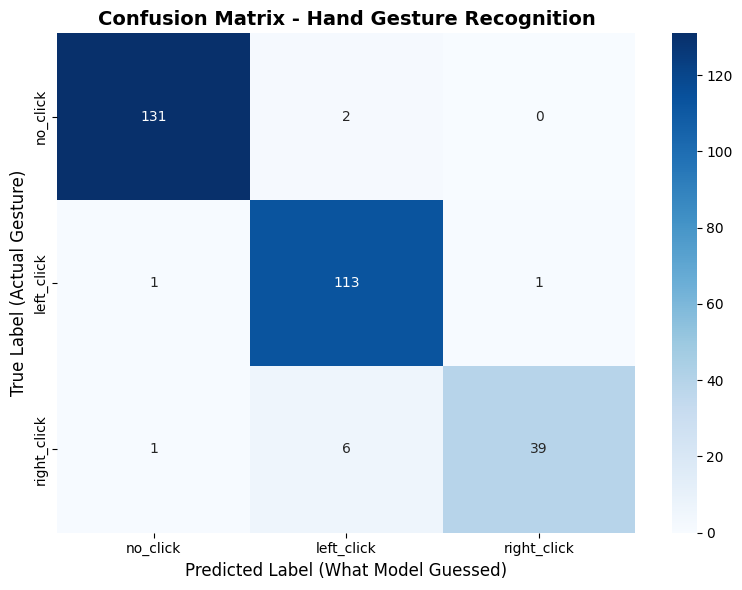

In [172]:
# Section 12: Visualization

# Create confusion matrix to visualize model performance
# Generate confusion matrix from predictions and true labels
cm = confusion_matrix(y_test, y_pred)

# Create visualization of confusion matrix
plt.figure(figsize=(8, 6))
# Use seaborn heatmap for better visualization
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=GESTURE_CLASSES, yticklabels=GESTURE_CLASSES)
plt.title('Confusion Matrix - Hand Gesture Recognition', fontsize=14, fontweight='bold')
plt.ylabel('True Label (Actual Gesture)', fontsize=12)
plt.xlabel('Predicted Label (What Model Guessed)', fontsize=12)
plt.tight_layout()
plt.show()
